In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.cuda.amp import autocast, GradScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import random
import glob
import cv2
import os
from torchvision.models.video import r3d_18
import torchvision
import ast  

In [3]:
def extract_frames(video_path, output_folder, num_frames=16):
    os.makedirs(output_folder, exist_ok=True)
    
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frame_indices = [int(i * total_frames / num_frames) for i in range(num_frames)]
    count = 0
    
    for i in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        if i in frame_indices:
            frame_filename = os.path.join(output_folder, f"frame_{count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            count += 1
    
    cap.release()

extract_frames("dog_video.mp4", "output_frames", num_frames=16)

In [4]:
input_folder = "/kaggle/input/dogs-pose/data_updated"  
output_folder = "frames_dataset"

for category in os.listdir(input_folder):
    category_path = os.path.join(input_folder, category)
    
    if not os.path.isdir(category_path):
        continue  
    
    for subcategory in os.listdir(category_path):
        subcategory_path = os.path.join(category_path, subcategory)
        output_subfolder = os.path.join(output_folder, category, subcategory)
        
        os.makedirs(output_subfolder, exist_ok=True)
        
        for video_file in glob.glob(os.path.join(subcategory_path, "*.mp4")):
            video_name = os.path.splitext(os.path.basename(video_file))[0]
            extract_frames(video_file, os.path.join(output_subfolder, video_name), num_frames=16)


In [5]:
import os
import pandas as pd

def create_annotation_file(frames_root="/kaggle/working/frames_dataset", output_csv="/kaggle/working/train.csv"):
    data = []
    
    for category in os.listdir(frames_root):  
        category_path = os.path.join(frames_root, category)
        if not os.path.isdir(category_path):
            continue
        
        for subcategory in os.listdir(category_path):  
            subcategory_path = os.path.join(category_path, subcategory)
            if not os.path.isdir(subcategory_path):
                continue
            
            for video_folder in os.listdir(subcategory_path):  
                video_folder_path = os.path.join(subcategory_path, video_folder)
                frames = sorted(os.listdir(video_folder_path)) 
                frame_paths = [os.path.join(video_folder_path, frame) for frame in frames]
                
                if len(frame_paths) > 0:
                    data.append([frame_paths, category])  

    df = pd.DataFrame(data, columns=["frames", "label"])
    df.to_csv(output_csv, index=False)

create_annotation_file("frames_dataset", "train.csv")

In [6]:
data = pd.read_csv("/kaggle/working/train.csv")
data = data.sample(frac=1).reset_index(drop=True)

In [19]:
data.head()

array(['Standing+Sitting', 'Walking', 'Resting'], dtype=object)

In [20]:
train_transforms_1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])

])

In [21]:
class VideoFrameDataset(Dataset):
    def __init__(self, csv_file, transform=None, num_frames=16):
        self.data = pd.read_csv('/kaggle/working/train.csv')
        self.transform = transform
        self.num_frames = num_frames
        self.classes = sorted(self.data["label"].unique())  
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        frame_paths = ast.literal_eval(row["frames"])  
        label = self.class_to_idx[row["label"]]

        if len(frame_paths) >= self.num_frames:
            selected_frames = frame_paths[::len(frame_paths) // self.num_frames][:self.num_frames]
        else:
            selected_frames = frame_paths + [frame_paths[-1]] * (self.num_frames - len(frame_paths))  

        images = [Image.open(frame).convert("RGB") for frame in selected_frames]
        
        if self.transform:
            images = [self.transform(img) for img in images]

        return torch.stack(images), torch.tensor(label)


train_data, temp_data = train_test_split(data, test_size=0.25, stratify=data['label'])
valid_data, test_data = train_test_split(temp_data, test_size=0.25)

train_dataset = VideoFrameDataset("train.csv", transform=train_transforms_1, num_frames=8)
valid_dataset = VideoFrameDataset("valid.csv", transform=train_transforms_1, num_frames=8)
test_dataset = VideoFrameDataset("test.csv",transform=transform, num_frames=8)

frames, label = train_dataset[0]
print(frames.shape) 
print(label)  


torch.Size([8, 3, 224, 224])
tensor(2)


In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

for batch in train_dataloader:
    frames, labels = batch
    print(frames.shape)  
    print(labels)
    break

torch.Size([8, 8, 3, 224, 224])
tensor([1, 2, 0, 1, 1, 1, 1, 1])


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNN_LSTM(nn.Module):
    def __init__(self, num_classes, hidden_size=256, num_layers=1):
        super(CNN_LSTM, self).__init__()

        resnet = models.resnet18(pretrained=True)
        resnet.fc = nn.Identity()  
        self.cnn = resnet

        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.shape

        x = x.view(batch_size * seq_len, C, H, W)

        x = self.cnn(x)  

        x = x.view(batch_size, seq_len, -1)

        x, _ = self.lstm(x)

        x = x[:, -1, :]

        x = self.fc(x)
        
        return x

model = CNN_LSTM(num_classes=3).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

In [26]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [27]:
num_epochs = 30 
scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    train_loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for frames, labels in train_loop:
        frames, labels = frames.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(frames)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        train_loop.set_postfix(loss=loss.item(), accuracy=100 * train_correct / train_total)
    
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * train_correct / train_total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    torch.cuda.empty_cache()  

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for frames, labels in valid_dataloader:
            frames, labels = frames.to(device), labels.to(device)
            with autocast():
                outputs = model(frames)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(valid_dataloader)
    val_accuracy = 100 * val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_loss)
    lr = scheduler.get_last_lr()

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

<ipython-input-27-87e7742173e5>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/30:   0%|          | 0/83 [00:00<?, ?it/s]<ipython-input-27-87e7742173e5>:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/30: 100%|██████████| 83/83 [01:13<00:00,  1.13it/s, accuracy=69.4, loss=0.805]
<ipython-input-27-87e7742173e5>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/30: Train Loss: 0.7564, Train Acc: 69.44% | Val Loss: 0.7092, Val Acc: 71.10%


Epoch 2/30: 100%|██████████| 83/83 [01:12<00:00,  1.14it/s, accuracy=73.1, loss=0.583]


Epoch 2/30: Train Loss: 0.6516, Train Acc: 73.07% | Val Loss: 0.5671, Val Acc: 77.00%


Epoch 3/30: 100%|██████████| 83/83 [01:11<00:00,  1.17it/s, accuracy=77.5, loss=0.873]


Epoch 3/30: Train Loss: 0.5241, Train Acc: 77.46% | Val Loss: 0.4719, Val Acc: 81.09%


Epoch 4/30: 100%|██████████| 83/83 [01:13<00:00,  1.12it/s, accuracy=80.9, loss=0.263]


Epoch 4/30: Train Loss: 0.4747, Train Acc: 80.94% | Val Loss: 0.3424, Val Acc: 86.84%


Epoch 5/30: 100%|██████████| 83/83 [01:13<00:00,  1.13it/s, accuracy=84.7, loss=0.539] 


Epoch 5/30: Train Loss: 0.3836, Train Acc: 84.72% | Val Loss: 0.3043, Val Acc: 88.50%


Epoch 6/30: 100%|██████████| 83/83 [01:14<00:00,  1.12it/s, accuracy=89.9, loss=0.164] 


Epoch 6/30: Train Loss: 0.2643, Train Acc: 89.86% | Val Loss: 0.2224, Val Acc: 91.68%


Epoch 7/30: 100%|██████████| 83/83 [01:12<00:00,  1.15it/s, accuracy=90.8, loss=0.0467]


Epoch 7/30: Train Loss: 0.2476, Train Acc: 90.77% | Val Loss: 0.1702, Val Acc: 94.55%


Epoch 8/30: 100%|██████████| 83/83 [01:11<00:00,  1.16it/s, accuracy=90.6, loss=0.169] 


Epoch 8/30: Train Loss: 0.2351, Train Acc: 90.62% | Val Loss: 0.1295, Val Acc: 95.92%


Epoch 9/30: 100%|██████████| 83/83 [01:12<00:00,  1.14it/s, accuracy=93.6, loss=0.36]  


Epoch 9/30: Train Loss: 0.1588, Train Acc: 93.65% | Val Loss: 0.1131, Val Acc: 96.22%


Epoch 10/30: 100%|██████████| 83/83 [01:14<00:00,  1.11it/s, accuracy=95.3, loss=0.0182]


Epoch 10/30: Train Loss: 0.1311, Train Acc: 95.31% | Val Loss: 0.0880, Val Acc: 96.82%


Epoch 11/30: 100%|██████████| 83/83 [01:12<00:00,  1.15it/s, accuracy=95.9, loss=0.663] 


Epoch 11/30: Train Loss: 0.1159, Train Acc: 95.92% | Val Loss: 0.0798, Val Acc: 97.13%


Epoch 12/30: 100%|██████████| 83/83 [01:13<00:00,  1.13it/s, accuracy=95.2, loss=0.0812]


Epoch 12/30: Train Loss: 0.1109, Train Acc: 95.16% | Val Loss: 0.0758, Val Acc: 97.28%


Epoch 13/30: 100%|██████████| 83/83 [01:13<00:00,  1.13it/s, accuracy=95.5, loss=0.228]  


Epoch 13/30: Train Loss: 0.1102, Train Acc: 95.46% | Val Loss: 0.0681, Val Acc: 97.43%


Epoch 14/30: 100%|██████████| 83/83 [01:12<00:00,  1.15it/s, accuracy=97.1, loss=0.366]  


Epoch 14/30: Train Loss: 0.0791, Train Acc: 97.13% | Val Loss: 0.0518, Val Acc: 98.18%


Epoch 15/30: 100%|██████████| 83/83 [01:11<00:00,  1.17it/s, accuracy=96.8, loss=0.303]  


Epoch 15/30: Train Loss: 0.0714, Train Acc: 96.82% | Val Loss: 0.0562, Val Acc: 98.49%


Epoch 16/30: 100%|██████████| 83/83 [01:10<00:00,  1.17it/s, accuracy=97.9, loss=0.00566]


Epoch 16/30: Train Loss: 0.0619, Train Acc: 97.88% | Val Loss: 0.0451, Val Acc: 98.49%


Epoch 17/30: 100%|██████████| 83/83 [01:10<00:00,  1.17it/s, accuracy=96.7, loss=0.00535]


Epoch 17/30: Train Loss: 0.0748, Train Acc: 96.67% | Val Loss: 0.0447, Val Acc: 98.34%


Epoch 18/30: 100%|██████████| 83/83 [01:12<00:00,  1.15it/s, accuracy=98.3, loss=0.018]  


Epoch 18/30: Train Loss: 0.0568, Train Acc: 98.34% | Val Loss: 0.0329, Val Acc: 98.94%


Epoch 19/30: 100%|██████████| 83/83 [01:11<00:00,  1.16it/s, accuracy=97.7, loss=0.0208] 


Epoch 19/30: Train Loss: 0.0603, Train Acc: 97.73% | Val Loss: 0.0391, Val Acc: 98.64%


Epoch 20/30: 100%|██████████| 83/83 [01:10<00:00,  1.18it/s, accuracy=97.7, loss=0.0108] 


Epoch 20/30: Train Loss: 0.0683, Train Acc: 97.73% | Val Loss: 0.0349, Val Acc: 98.94%


Epoch 21/30: 100%|██████████| 83/83 [01:12<00:00,  1.14it/s, accuracy=98.3, loss=0.00785]


Epoch 21/30: Train Loss: 0.0488, Train Acc: 98.34% | Val Loss: 0.0371, Val Acc: 99.24%


Epoch 22/30: 100%|██████████| 83/83 [01:12<00:00,  1.15it/s, accuracy=97.7, loss=0.00382]


Epoch 22/30: Train Loss: 0.0543, Train Acc: 97.73% | Val Loss: 0.0284, Val Acc: 98.94%


Epoch 23/30: 100%|██████████| 83/83 [01:12<00:00,  1.15it/s, accuracy=98.5, loss=0.00944]


Epoch 23/30: Train Loss: 0.0439, Train Acc: 98.49% | Val Loss: 0.0317, Val Acc: 99.09%


Epoch 24/30: 100%|██████████| 83/83 [01:13<00:00,  1.13it/s, accuracy=98.8, loss=0.0953] 


Epoch 24/30: Train Loss: 0.0438, Train Acc: 98.79% | Val Loss: 0.0274, Val Acc: 99.09%


Epoch 25/30: 100%|██████████| 83/83 [01:10<00:00,  1.18it/s, accuracy=98.5, loss=0.0088] 


Epoch 25/30: Train Loss: 0.0482, Train Acc: 98.49% | Val Loss: 0.0266, Val Acc: 99.39%


Epoch 26/30: 100%|██████████| 83/83 [01:11<00:00,  1.15it/s, accuracy=98.5, loss=0.11]   


Epoch 26/30: Train Loss: 0.0345, Train Acc: 98.49% | Val Loss: 0.0247, Val Acc: 99.39%


Epoch 27/30: 100%|██████████| 83/83 [01:11<00:00,  1.17it/s, accuracy=98.5, loss=0.0202] 


Epoch 27/30: Train Loss: 0.0389, Train Acc: 98.49% | Val Loss: 0.0270, Val Acc: 99.55%


Epoch 28/30: 100%|██████████| 83/83 [01:11<00:00,  1.17it/s, accuracy=98.2, loss=0.00607]


Epoch 28/30: Train Loss: 0.0447, Train Acc: 98.18% | Val Loss: 0.0263, Val Acc: 99.55%


Epoch 29/30: 100%|██████████| 83/83 [01:10<00:00,  1.17it/s, accuracy=98.2, loss=0.0203] 


Epoch 29/30: Train Loss: 0.0392, Train Acc: 98.18% | Val Loss: 0.0256, Val Acc: 99.09%


Epoch 30/30: 100%|██████████| 83/83 [01:12<00:00,  1.15it/s, accuracy=98.5, loss=0.149]  


Epoch 30/30: Train Loss: 0.0436, Train Acc: 98.49% | Val Loss: 0.0277, Val Acc: 99.24%


Text(0.5, 1.0, 'Training and Validation Loss')

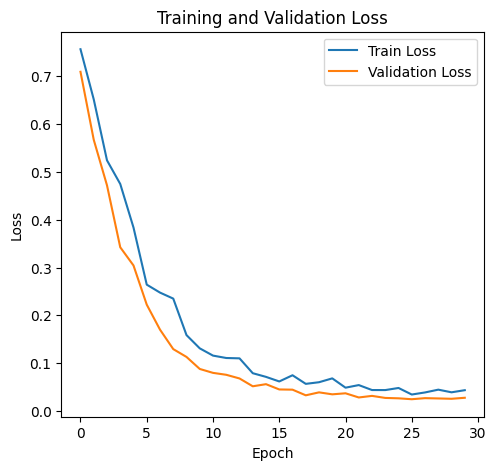

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

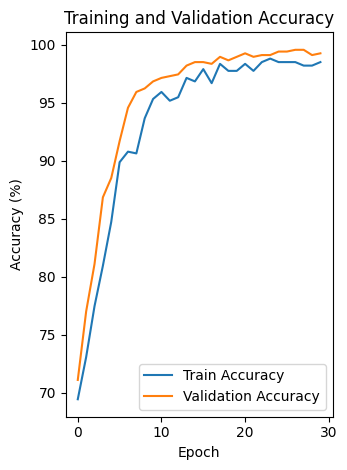

In [29]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [30]:
def evaluate(model, test_loader):
    model.eval()  
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():  
        for frames, labels in test_loader:
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)  
            _, predicted = torch.max(outputs, 1)  

            total += labels.size(0)  
            correct += (predicted == labels).sum().item()

            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

    accuracy = 100 * correct / total
    return accuracy, torch.cat(all_preds), torch.cat(all_labels)

accuracy, all_preds, all_labels = evaluate(model, test_dataloader)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 98.18%


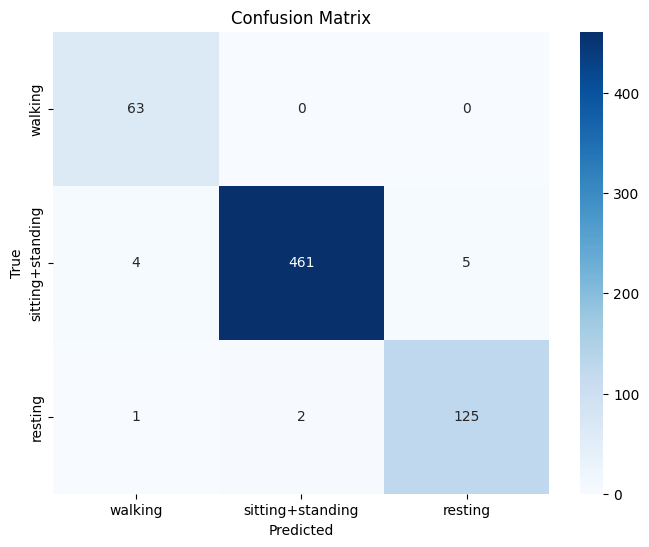

In [32]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["walking", "sitting+standing", "resting"], yticklabels=["walking", "sitting+standing", "resting"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model_path = "dog_pose_model_final.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, model_path)
print(f"Модель збережена у {model_path}")

Модель збережена у dog_pose_model_best_advanced_5.pth
